# FINAL PROJECT : Carry Trade and Momentum

## Inspiration



In the homework where we implement a carry trade strategy with four foreign currencies, I found that the strategy performance in some of the currencies can be not that satisfying, which leads me to think about if we can use some method to adjust the weight of our position in each different currency. Instead of trying to investigate into some economic models that predict the bond and foreign exchange market moving trend, I get my idea of modification of the original carry trade strategy from Burnside et al.(2011) just by using momentum. Then I applied some methods from Daniel et al.(2016) to analyse the strategy with some risk factors. 

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import scipy.stats as ss
import statsmodels.api as sm
import datetime

## Data
Below is the process I got money market, yield curve and fx data from quandl. Here I only focused on the currencies of Thailand, Roumania, Japan, Indonesia and South Korea.

In [2]:
#prepare data

api_key = "khzKyrGRmxZen9BA5h9a"
currency = ['THA','ROU','JPN','IDN','KOR']
yc = {}
for c in currency:
    yc[c] = quandl.get('YC/'+c,returns="pandas",api_key=api_key)
libor = {}
libor['THA'] = quandl.get('YC/THA3M',returns="pandas",api_key=api_key)
libor['ROU'] = quandl.get('YC/ROU6M',returns="pandas",api_key=api_key)
libor['JPN'] = quandl.get('YC/JPN1Y',returns="pandas",api_key=api_key)
libor['IDN'] = quandl.get('YC/IDN1Y',returns="pandas",api_key=api_key)
libor['KOR'] = quandl.get('YC/KOR3M',returns="pandas",api_key=api_key)

currency2 = ['THB','RON','JPY','IDR','KRW']
fx = {}
for i in range(5):
    fx[currency[i]] = quandl.get('CUR/'+currency2[i])

This part of code is basically the same as our carry trade homework, where we used the method suggested to estimate zero rates from yield curves.

In [3]:
#calculate zero rates
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
    return zcb_rates

In [4]:
#select tenors we need
tenor_map = {'THA':[int(x.split('-')[0]) for x in yc['THA'].columns][3:8],\
             'ROU':[1,3,5],\
             'JPN':[int(x.split('-')[0]) for x in yc['JPN'].columns][:5],\
             'IDN':[int(x.split('-')[0]) for x in yc['IDN'].columns][:5],\
             'KOR':[int(x.split('-')[0]) for x in yc['KOR'].columns][2:6]}
yc['ROU'] = yc['ROU'].rename(columns = {'12-Month':'1-Year'})    


#transpose to prepare for trasition from spot rate to zero rate
spot_rates = {}
for c in currency:
    yc[c] = yc[c][[str(t)+'-Year' for t in tenor_map[c]]]
    df = yc[c].transpose().set_index(pd.Series(tenor_map[c]))
    spot_rates[c] = df*0.01
    
zero_rates = {}
for c in currency:
    zero_rates[c] = compute_zcb_curve(spot_rates[c])

To maximize the profit, I plot the money market rate to check the most cheap borrowing currency, which turn out to be the Japanese yen

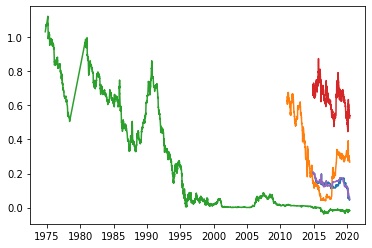

In [5]:
#look up the borrowing rate and decide which currency to borrow and which currency to borrow
libor['JPN'] = libor['JPN'].rename(columns = {'Yield':'Rate'})
for x in currency:
    libor[x] *= 0.1
    plt.plot(libor[x])

## Strategy
My trading period is from 2014-12-03 and 2020-05-07.
On every Wednesday, I check the rank of previous week gain, and enter into different positions for different currencies corresponding to the rank.
So here I just firstly get the date value of every Wednesday. But it's likely at some dates, not all currencies have the zero rates we need to exit and enter, so I'll just put off to the day when we have all currencies that have data we can use to trade.

In [7]:
def getEveryDay(begin_date,end_date): 
    date_list = [] 
    begin_date = datetime.datetime.strptime(begin_date, "%Y-%m-%d") 
    end_date = datetime.datetime.strptime(end_date,"%Y-%m-%d") 
    while begin_date <= end_date: 
        date_str = begin_date.strftime("%Y-%m-%d") 
        date_list.append(pd.Timestamp(date_str)) 
        begin_date += datetime.timedelta(days=7) 
    return date_list 

In [8]:
begin = '2014-12-03'
end = '2020-04-30'
dates = getEveryDay(begin,end)
actual_dates = []
for i in range(len(dates)):
    date = dates[i]
    while (date in zero_rates['THA'].columns and date in zero_rates['ROU'].columns and\
           date in zero_rates['IDN'].columns and date in zero_rates['KOR'].columns and\
           date in libor['JPN'].index) == False:
        date += pd.Timedelta(days = 1)
    if date not in actual_dates:
        actual_dates.append(date)

Initiate the cashflow to record cash flow of every part of trading at every trading day. Also since at the first trading day, we don't have data of previous gain, so I just use the 5 year zero rates to get the initial rank.

In [10]:
cashflow = pd.DataFrame(index = actual_dates,columns={'THA','ROU','IDN','KOR',\
                                                      'Lend_out','JPN','Borrow_in'})
ranks = pd.DataFrame(index = actual_dates,columns = ['THA','ROU','IDN','KOR'])

initial_rank = ss.rankdata([zero_rates[c].loc[5,actual_dates[0]] for c in ['THA','ROU','IDN','KOR']])
ranks.loc[actual_dates[0]] = ({'THA':initial_rank[0],'ROU':initial_rank[1],'IDN':initial_rank[2],'KOR':initial_rank[3]})

### Specific Strategy

The leverage for this strategy is 5/4. Every trading day, I borrow the Japanese yen that worth 8MM dollars at that day, except the last trading day. Then, I lend 10MM in different currency markets according to the rank of previous gain. For example, the gains of last trading from THA, ROU, IDN and KOR have a rank like [3,4,2,1], then at this trading day, I lend 3MM, 4MM, 2MM, and 1MM dollars in those four countries' 5-year maturity bond market at the current fx rate. Then next trading day, I'll collect cash back by selling the bonds and convert back to USD. For the borrowing side, the cost of yen is assumed to be 50 basis point + libor of yen. 

In [11]:
cashflow.loc[actual_dates[0]:actual_dates[-1],'Lend_out'] = -10
cashflow.loc[actual_dates[-1],'Lend_out'] = 0
cashflow.loc[actual_dates[0]:actual_dates[-1],'Borrow_in'] = 8
cashflow.loc[actual_dates[-1],'Borrow_in'] = 0

In [13]:
#get interest rate of shortened maturity
def get_ir(curve,td):
    z = np.interp(5-td, curve.index.values, curve.values)
    return z

Since I found the maximum drawdown can be really large when I didn't employ any method to stop loss in that carrytrade homework, I decide to set a stop loss point. So the idea of the code below is firstly I assume I don't exit for one currency if it's not at a trading day. Then I iterate the dates that are between the last trading day and this trading day for each currency, if I find a day when the position converted to USD has loss exceeding my stop loss point, I'll exit that currency market at that day and update the real cash inflow. For the rank, every trading day, I update the rank by comparing the last week gain. So I generate the plot of total cashflow, statistics of returns and histograms below.

In [16]:
def get_cashflow_return(stop_loss):
    for i in range(1,len(actual_dates)):
        date = actual_dates[i]
        timedelta = (date-actual_dates[i-1]).days/7/52
        
        for c in ['THA','ROU','IDN','KOR']:
            ir = get_ir(zero_rates[c][date],timedelta)
            ir_old = zero_rates[c].loc[5,actual_dates[i-1]]
            fx_old = fx[c].loc[actual_dates[i-1],'RATE']
            weight = ranks.loc[actual_dates[i-1],c]
            lend_in = weight*fx_old/(np.exp(-ir_old*5))*np.exp(-ir*(5-timedelta))/fx[c].loc[date,'RATE']
            
            
            #for stop loss
            days = [d for d in zero_rates[c].columns if ((d<date) & (d>actual_dates[i-1]))]
            for d in days:
                new_timedelta = (d-actual_dates[i-1]).days/7/52
                new_lend_in = weight*fx_old/(np.exp(-ir_old*5))*np.exp(-ir*(5-new_timedelta))/fx[c].loc[d,'RATE']
                if (new_lend_in/weight)-1 < -stop_loss: 
                    lend_in = new_lend_in
                    break
            cashflow.loc[date,c] = lend_in
        
        #update the rank
        new_rank = ss.rankdata(list(cashflow[['THA','ROU','IDN','KOR']].loc[date]\
                                    .divide(ranks.loc[actual_dates[i-1]])))
        ranks.loc[date] = ({'THA':new_rank[0],'ROU':new_rank[1],'IDN':new_rank[2],'KOR':new_rank[3]})
        
        
        ir_old_jpn = libor['JPN'].loc[actual_dates[i-1],'Rate']
        fx_old_jpn = fx['JPN'].loc[actual_dates[i-1],'RATE']
        jpn_out = -8*fx_old_jpn*(1+(ir_old_jpn+0.0001*50)*timedelta)/fx['JPN'].loc[date,'RATE']
        cashflow.loc[date,'JPN'] = jpn_out
        
           
    total_cash = cashflow.sum(axis=1)
    print("-------------------------------------------------------")
    print("When stop_loss = "+str(stop_loss))
    plt.figure()
    plt.plot(total_cash.cumsum(),label = str(stop_loss))
    plt.legend(loc = 'upper left')
    plt.title("Cash flow of the strategy when stop_loss = "+str(stop_loss))
    
    #get return
    total_cash.loc[actual_dates[0]] += 2
    total_cash.loc[actual_dates[-1]] -= 2
    ret = total_cash/2.0
    print("-------------------------------------------------------")
    print("Summary of statistics of weekly return")
    print(ret.describe())
    print("Skewness of return series is "+str(ret.skew()))
    print("Kurtosis of return series is "+str(ret.kurtosis()))
    print("Sharpe of return series is "+str(ret.mean()/ret.std()))
    print("-------------------------------------------------------")
    plt.figure()
    ret.hist()
    plt.title("Histogram of the weekly return when stop_loss = "+str(stop_loss))

-------------------------------------------------------
When stop_loss = 0.05
-------------------------------------------------------
Summary of statistics of weekly return
count    277.000000
mean       0.001932
std        0.052794
min       -0.206905
25%       -0.028226
50%        0.000770
75%        0.032388
max        0.165520
dtype: float64
Skewness of return series is -0.1525103651777615
Kurtosis of return series is 1.3004021329827915
Sharpe of return series is 0.03660316170230702
-------------------------------------------------------


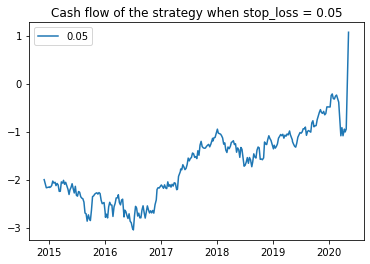

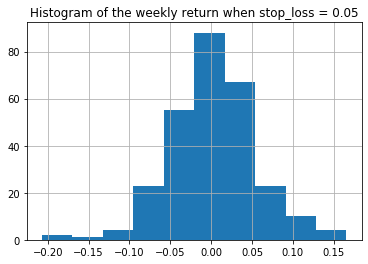

In [17]:
stop_losses = [0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
get_cashflow_return(stop_losses[0])

-------------------------------------------------------
When stop_loss = 0.01
-------------------------------------------------------
Summary of statistics of weekly return
count    277.000000
mean       0.002133
std        0.051814
min       -0.218425
25%       -0.027026
50%        0.000410
75%        0.032840
max        0.165520
dtype: float64
Skewness of return series is -0.1377469047308632
Kurtosis of return series is 1.504845443709462
Sharpe of return series is 0.041163974272159336
-------------------------------------------------------


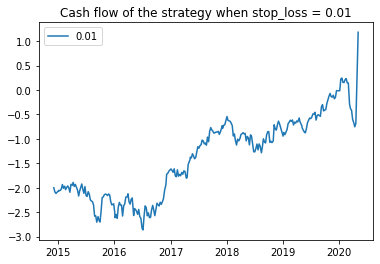

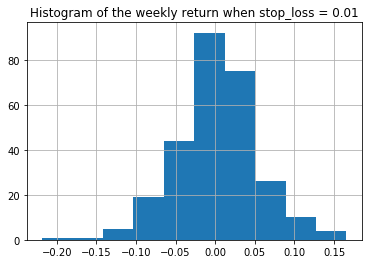

In [18]:
get_cashflow_return(stop_losses[1])

-------------------------------------------------------
When stop_loss = 0.005
-------------------------------------------------------
Summary of statistics of weekly return
count    277.000000
mean       0.003035
std        0.051328
min       -0.200066
25%       -0.024685
50%        0.002071
75%        0.031678
max        0.165520
dtype: float64
Skewness of return series is -0.18326287493402657
Kurtosis of return series is 1.6813954972042109
Sharpe of return series is 0.059119963973094006
-------------------------------------------------------


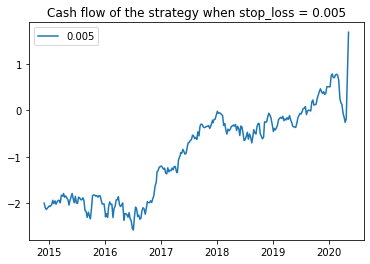

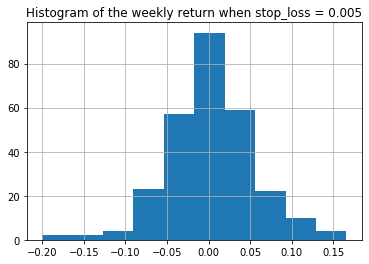

In [19]:
get_cashflow_return(stop_losses[2])

-------------------------------------------------------
When stop_loss = 0.001
-------------------------------------------------------
Summary of statistics of weekly return
count    277.000000
mean       0.003472
std        0.050213
min       -0.200066
25%       -0.026387
50%        0.003703
75%        0.030147
max        0.162528
dtype: float64
Skewness of return series is -0.20426346570927142
Kurtosis of return series is 1.5275484962809291
Sharpe of return series is 0.06914721893336104
-------------------------------------------------------


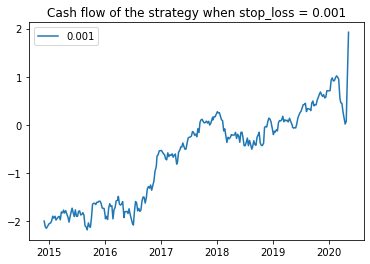

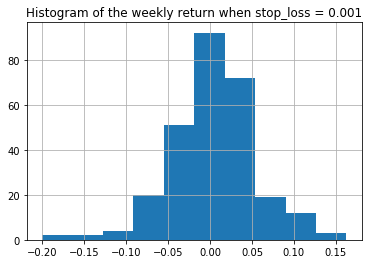

In [20]:
get_cashflow_return(stop_losses[3])

-------------------------------------------------------
When stop_loss = 0.0005
-------------------------------------------------------
Summary of statistics of weekly return
count    277.000000
mean       0.003870
std        0.050390
min       -0.200066
25%       -0.026387
50%        0.004904
75%        0.030161
max        0.162528
dtype: float64
Skewness of return series is -0.20891800348578138
Kurtosis of return series is 1.5371418301963051
Sharpe of return series is 0.07679692775475007
-------------------------------------------------------


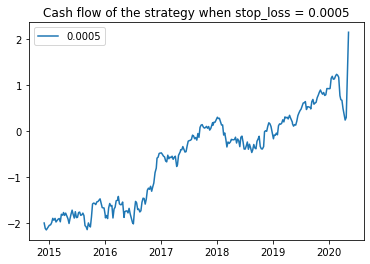

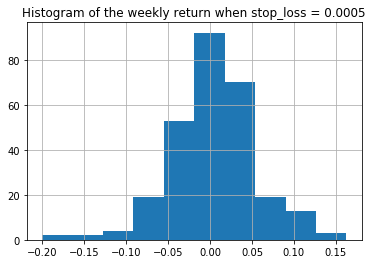

In [21]:
get_cashflow_return(stop_losses[4])

-------------------------------------------------------
When stop_loss = 0.0001
-------------------------------------------------------
Summary of statistics of weekly return
count    277.000000
mean       0.004303
std        0.050163
min       -0.200066
25%       -0.024887
50%        0.005246
75%        0.032520
max        0.162528
dtype: float64
Skewness of return series is -0.2360100574632055
Kurtosis of return series is 1.6176543113224198
Sharpe of return series is 0.08577162810136013
-------------------------------------------------------


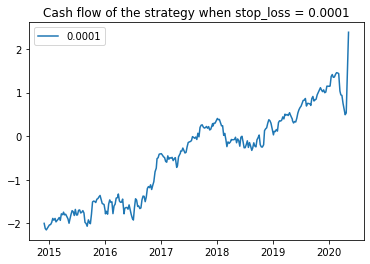

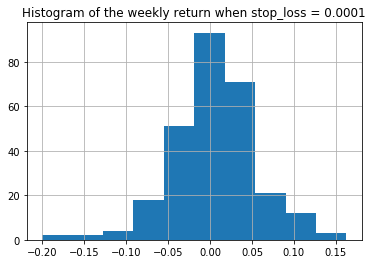

In [22]:
get_cashflow_return(stop_losses[5])

-------------------------------------------------------
When stop_loss = 5e-05
-------------------------------------------------------
Summary of statistics of weekly return
count    277.000000
mean       0.004249
std        0.050152
min       -0.200066
25%       -0.024887
50%        0.005246
75%        0.032520
max        0.162528
dtype: float64
Skewness of return series is -0.23718054072198366
Kurtosis of return series is 1.6210539605630756
Sharpe of return series is 0.08471779013974368
-------------------------------------------------------


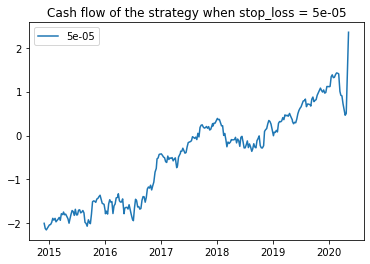

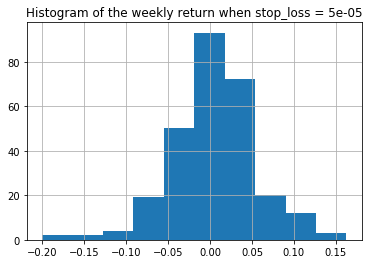

In [23]:
get_cashflow_return(stop_losses[6])

-------------------------------------------------------
When stop_loss = 1e-05
-------------------------------------------------------
Summary of statistics of weekly return
count    277.000000
mean       0.004479
std        0.050087
min       -0.200066
25%       -0.023492
50%        0.005251
75%        0.032520
max        0.162528
dtype: float64
Skewness of return series is -0.2475759955357643
Kurtosis of return series is 1.649536377807482
Sharpe of return series is 0.0894257544159047
-------------------------------------------------------


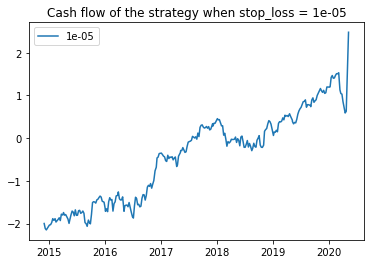

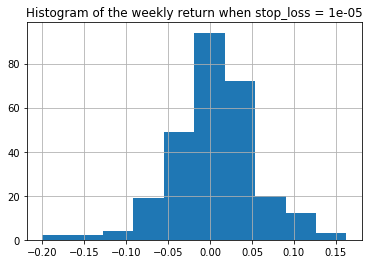

In [24]:
get_cashflow_return(stop_losses[7])

From all the statistics and plots above, as I decrease the stop loss point, the mean return of the strategy will increase but at some point, the stop loss point doesn't make a difference. Setting a smaller stop loss will avoid us lose money at dates between 2015-2017. Also we can see that actually the standard deviation doesn't vary much when we decrease the stop loss point. The cashflow plots show the intrinsic characteristic of volatile pnl of carry trading. Generally, carry trade return is very negatively skewed and here the strategy return shows slightly negative skewness. Decreasing the stop loss point will result in a less skewed return distribution. Generally, carry trade returns have fat-tailed distributions. The Sharpe ratio also goes up when I decrease the stop loss point.

Since at some point, the stop loss value doesn't make a significant difference to the return. So I use stop_loss = 0.0001 below to analyze the return from different perspectives.

## Analysis

### Carry trade without momentum

This part I contrast the performance of the strategy with a new strategy if we don't use rank every trading day. Therefore, we can check if the ranking has its meaning.

-------------------------------------------------------
When stop_loss = 0.0001
-------------------------------------------------------
Summary of statistics of weekly return
count    277.000000
mean       0.003985
std        0.050089
min       -0.204762
25%       -0.023079
50%        0.003973
75%        0.031468
max        0.151642
dtype: float64
Skewness of return series is -0.2910385836575499
Kurtosis of return series is 1.755289936482551
Sharpe of return series is 0.07955429020298432
-------------------------------------------------------


Text(0.5, 1.0, 'Histogram of the weekly return when stop_loss = 0.0001')

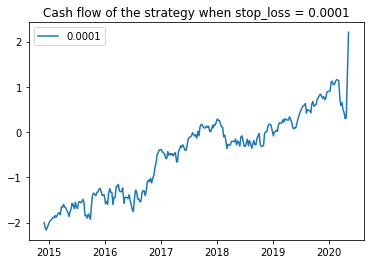

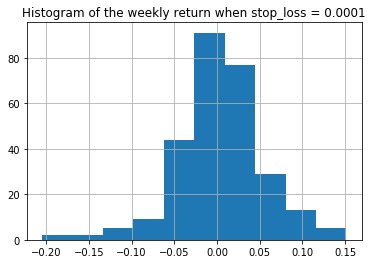

In [28]:
stop_loss = 0.0001
cashflow_c = pd.DataFrame(index = actual_dates,columns={'THA','ROU','IDN','KOR',\
                                                      'Lend_out','JPN','Borrow_in'})
cashflow_c.loc[actual_dates[0]:actual_dates[-1],'Lend_out'] = -10
cashflow_c.loc[actual_dates[-1],'Lend_out'] = 0
cashflow_c.loc[actual_dates[0]:actual_dates[-1],'Borrow_in'] = 8
cashflow_c.loc[actual_dates[-1],'Borrow_in'] = 0

for i in range(1,len(actual_dates)):
    date = actual_dates[i]
    timedelta = (date-actual_dates[i-1]).days/7/52
    
    for c in ['THA','ROU','IDN','KOR']:
        ir = get_ir(zero_rates[c][date],timedelta)
        ir_old = zero_rates[c].loc[5,actual_dates[i-1]]
        fx_old = fx[c].loc[actual_dates[i-1],'RATE']
        weight = 2.5
        lend_in = weight*fx_old/(np.exp(-ir_old*5))*np.exp(-ir*(5-timedelta))/fx[c].loc[date,'RATE']
        
        
        #for stop loss
        days = [d for d in zero_rates[c].columns if ((d<date) & (d>actual_dates[i-1]))]
        for d in days:
            new_timedelta = (d-actual_dates[i-1]).days/7/52
            new_lend_in = weight*fx_old/(np.exp(-ir_old*5))*np.exp(-ir*(5-new_timedelta))/fx[c].loc[d,'RATE']
            if (new_lend_in/weight)-1 < -stop_loss: 
                lend_in = new_lend_in
                break
        cashflow_c.loc[date,c] = lend_in
    
    ir_old_jpn = libor['JPN'].loc[actual_dates[i-1],'Rate']
    fx_old_jpn = fx['JPN'].loc[actual_dates[i-1],'RATE']
    jpn_out = -8*fx_old_jpn*(1+(ir_old_jpn+0.0001*50)*timedelta)/fx['JPN'].loc[date,'RATE']
    cashflow_c.loc[date,'JPN'] = jpn_out
    

print("-------------------------------------------------------")
print("When stop_loss = "+str(stop_loss))
total_cash_c = cashflow_c.sum(axis=1)
plt.figure()
plt.plot(total_cash_c.cumsum(),label = str(stop_loss))
plt.legend(loc = 'upper left')
plt.title("Cash flow of the strategy when stop_loss = "+str(stop_loss))

#get return
total_cash_c.loc[actual_dates[0]] += 2
total_cash_c.loc[actual_dates[-1]] -= 2
ret_c = total_cash_c/2.0
print("-------------------------------------------------------")
print("Summary of statistics of weekly return")
print(ret_c.describe())
print("Skewness of return series is "+str(ret_c.skew()))
print("Kurtosis of return series is "+str(ret_c.kurtosis()))
print("Sharpe of return series is "+str(ret_c.mean()/ret_c.std()))
print("-------------------------------------------------------")
plt.figure()
ret_c.hist()
plt.title("Histogram of the weekly return when stop_loss = "+str(stop_loss))

-------------------------------------------------------
When stop_loss = 0.0001
-------------------------------------------------------
Summary of statistics of weekly return
count    277.000000
mean       0.004303
std        0.050163
min       -0.200066
25%       -0.024887
50%        0.005246
75%        0.032520
max        0.162528
dtype: float64
Skewness of return series is -0.2360100574632055
Kurtosis of return series is 1.6176543113224198
Sharpe of return series is 0.08577162810136013
-------------------------------------------------------


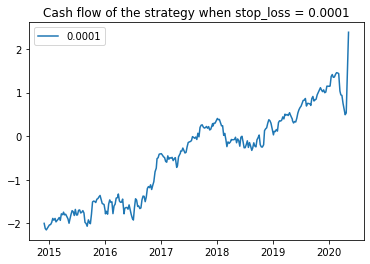

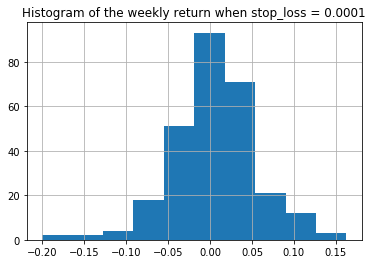

In [26]:
get_cashflow_return(stop_losses[5])

In [29]:
ss.ttest_ind(ret,ret_c)

Ttest_indResult(statistic=0.11612428021214963, pvalue=0.9075962793237123)

From the plots above, actually I can't see any significant difference. But the statistics show that the mean of returns increases from 0.003985 to 0.004303, which is about a 8% improvement. Although the t-test doesn't show significance, I think that's because we only trade 5 currencies and have a small sample time. The Sharpe ratio increases from 0.079554 to 0.085771.

Though the standard deviation doesn't vary much, the change of skewness says applying momentum to the trading process can be help improve the performance of carrytrade when it comes to the negative side of returns.

### Carry trade and stocks

In this part, I want to compare the return of a general stock performance and the carry trade trading strategy. So I use the SPY Adjusted Close price to calculate the weekly return and see its statistics. I align the trading day of my strategy with the SPY price date, and if I cannot find my trading day existing in the SPY data, I'll use the closest day's price. Then the return of SPY can have the similar covering period corresponding to the strategy return.

-------------------------------------------------------
Summary of statistics of weekly return of SPY
           return
count  276.000000
mean     0.001842
std      0.022474
min     -0.206962
25%     -0.004588
50%      0.004025
75%      0.011888
max      0.130205
Skewness of return series is return   -2.733197
dtype: float64
Kurtosis of return series is return    30.665364
dtype: float64
Sharpe of return series is return    0.081955
dtype: float64
-------------------------------------------------------


Text(0.5, 1.0, 'Histogram of the weekly return if SPY')

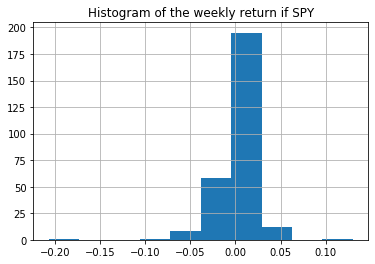

In [30]:
#%% contrast with spy
spy = quandl.get('EOD/SPY', start_date='2014-12-03', end_date='2020-05-07')
#%% need to align the trading day with spy dates
spy_aligned = pd.DataFrame(index = actual_dates, columns = {'spy'})
for i in range(len(actual_dates)):
    if actual_dates[i] in spy.index:
        spy_aligned.loc[actual_dates[i],'spy'] = spy.loc[actual_dates[i],'Adj_Close']
    else:
        dates_seg1 = [d for d in spy.index if d < actual_dates[i]]
        dates_seg2 = [d for d in spy.index if d > actual_dates[i]]
        if (dates_seg2[0]-actual_dates[i]).days >= (actual_dates[i]-dates_seg1[-1]).days:
             spy_aligned.loc[actual_dates[i],'spy'] = spy.loc[dates_seg1[-1],'Adj_Close']
        else:
            spy_aligned.loc[actual_dates[i],'spy'] = spy.loc[dates_seg2[0],'Adj_Close']
spy_aligned['return'] = spy_aligned['spy'].diff()/spy_aligned['spy'].shift(1)
ret_spy = pd.DataFrame(spy_aligned['return'])
ret_spy = ret_spy.astype(float)

print("-------------------------------------------------------")
print("Summary of statistics of weekly return of SPY")
print(ret_spy.describe())
print("Skewness of return series is "+str(ret_spy.skew()))
print("Kurtosis of return series is "+str(ret_spy.kurtosis()))
print("Sharpe of return series is "+str(ret_spy.mean()/ret_spy.std()))
print("-------------------------------------------------------")
plt.figure()
ret_spy['return'].hist()
plt.title("Histogram of the weekly return if SPY")

Recall what we have when we set the stop loss point to be 0.0001. The mean return is about 0.004303 and here the mean return of SPY is 0.001842. For the standard deviation, the strategy has 0.050163 while SPY has much smaller std of 0.022474. Therefore, carry trade is still considered very volatile even if I apply momentum and stop loss. The strategy has Sharpe of 0.085772 and the SPY has Sharpe of 0.081955. So considering the volatility, the strategy is not much better than just passively trading stock index.This is probably due to our volatility measure treats the postive tail return and negative tail return the same way. 

But something I noticed is that I didn't expect the skewness of SPY returns can be much more negative than the strategy return. Because we know carry trade is often faced with downside risk since it's like selling options I expect it will be more negatively skewed than stock returns. Therefore, I think here the strategy works better than just passively trading stock index. Also, the kurtosis of SPY return is much larger than the strategy kurtosis.

### Carry trade and 3 factors

In this part, I want to test if the return of the strategy can be explained by FF three factors in the US stock market.Therefore I can check if the return has some significant alpha and the correlation between bond, fx market and US stock market.

In [31]:
ff= pd.read_csv(r"C:\Users\Krist\OneDrive\desktop\quant strategies\final\F-F_Research_Data_Factors_weekly.csv")
ff = ff.rename(columns = {'Unnamed: 0':'Date'})
ff['Date'] = ff['Date'].apply(lambda x: str(x))
ff = ff.loc[ff['Date']>="20141203"]
ff['Date'] = ff['Date'].apply(lambda x: pd.Timestamp(datetime.datetime.strptime(x, "%Y%m%d").strftime("%Y-%m-%d")))
ff = ff.set_index("Date")

I found that the weekly 3 factors publishing time are changing so I aligned the strategy trading days with the factor date. For example, if I cannot find the factor data for a trading day, I'll search for the most recent pulish time.

In [32]:
ret = pd.DataFrame(ret)
test = ret.join(ff,how = 'outer')

#since our trading day actually doesn't align with the ff weekly published factors.
test_dates = list(test.index)
for i in range(len(actual_dates)-1,0,-1):
    dates_seg = [d for d in test_dates if d <= actual_dates[i]]
    for j in range(len(dates_seg)-1,0,-1):
        if pd.isnull(test[['Mkt-RF','SMB','HML']].loc[dates_seg[j]]).all() == False:
            for f in ['Mkt-RF','SMB','HML']:
                test.loc[actual_dates[i],f] = test.loc[dates_seg[j],f]
                test.loc[dates_seg[j],f] = np.nan
            break
test = test.loc[actual_dates]
test = test.drop(columns = {'RF'})
test = test.loc[actual_dates[1]:]

Since I am just checking the significance of factors but not doing predictions, I just use the plain OLS regression here. The dependent variable is just the return of the strategy, the independent variables are just three factors. In most of the papers they use GMM to estimate the model, here I simply the process.

In [33]:
Y = test[0]
X = test[test.columns[1:4]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.777
Date:                Thu, 04 Jun 2020   Prob (F-statistic):             0.0417
Time:                        16:25:26   Log-Likelihood:                 438.88
No. Observations:                 276   AIC:                            -869.8
Df Residuals:                     272   BIC:                            -855.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.003      1.490      0.137      -0.001       0.010
Mkt-RF         0.0028      0.001      2.143      0.033       0.000       0.005
SMB            0.0015      0.003      0.584      0.560      -0.004       0.007
HML            0.0020      0.002      1.000      0.318      -0.002       0.006
==============================================================================
Omnibus:                       16.862   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.827
Skew:                          -0.337   Prob(JB):                     2.02e-07
Kurtosis:                       4.492   Cond. No.                         2.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see, the R square is actually really small for this regression. But it's interesting that the market factor has a significant t value, indicating that US stock market returns can be used to explain part of the strategy return. However, what we are mainly trading is the Asian bond market and currency market. So I guess it's probably because of some economic regime that connects bond, fx and stock market together. One thing I think of is that when the US stock market performs better, it may result in the relative deprecation of our borrowing currency and our cost of borrowing decreases, leading to a better strategy return. And this effect must offset the deprecation effects from lending side. 

Although I can't see a significant intercept here, the t value is 1.49 and it's impressive. I think maybe if we cover more currency and longer trading period in our strategy, there can be a siginificant alpha when we do the regression on the 3 factors. If that's the case, carry trade with momentum can be a good choice for investors besides stock factor investing. And we can also see there are no significant correlations between the other two factors and the strategy return.

### Carry trade and bond factors

In this part, I want to test if the return of the strategy can be explained by bond factors in the US bond market. So I use two bond factors which are credit factor and term factor. The credit factor is provided by Merrill Lynch's US Corporate Bond Index Yield from Quandl. The term factor is contructed by subtracting 2-year treasury rate from 10-year treasury rate. 

In [34]:
#get data of bond factors
credit = quandl.get("ML/USEY", authtoken="khzKyrGRmxZen9BA5h9a")
term = quandl.get("YC/USA", authtoken="khzKyrGRmxZen9BA5h9a")

I found not all trading days can be matched with the factor date, so I aligned the strategy trading days with the factor date. For example, if I cannot find the factor data for a trading day, I'll search for the most recent pulished factor.

In [35]:
test1 = pd.DataFrame(index = actual_dates,columns = {'ret','credit','term'})
for i in range(len(actual_dates)):
    if actual_dates[i] in credit.index:
        test1.loc[actual_dates[i],'credit'] = credit.loc[actual_dates[i],'BAMLC0A0CMEY']
    else:
        dates_seg = [d for d in credit.index if d < actual_dates[i]]
        test1.loc[actual_dates[i],'credit'] = credit.loc[dates_seg[-1],'BAMLC0A0CMEY']
    if actual_dates[i] in term.index:
        test1.loc[actual_dates[i],'term'] = term.loc[actual_dates[i],'10-Year'] - term.loc[actual_dates[i],'2-Year']
    else:
        dates_seg = [d for d in term.index if d < actual_dates[i]]
        test1.loc[actual_dates[i],'term'] = term.loc[dates_seg[-1],'10-Year'] - term.loc[dates_seg[-1],'2-Year']

test1['ret'] = ret[0]

In [36]:
Y = test1['ret']
X = test1[['credit','term']]
X = sm.add_constant(X)
model = sm.OLS(Y,X.astype(float))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.1767
Date:                Thu, 04 Jun 2020   Prob (F-statistic):              0.838
Time:                        16:47:28   Log-Likelihood:                 436.97
No. Observations:                 277   AIC:                            -867.9
Df Residuals:                     274   BIC:                            -857.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0181      0.026      0.685      0.494      -0.034       0.070
credit        -0.0041      0.007     -0.563      0.574      -0.018       0.010
term           0.0002      0.006      0.034      0.973      -0.012       0.013
==============================================================================
Omnibus:                       15.534   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.974
Skew:                          -0.237   Prob(JB):                     6.91e-08
Kurtosis:                       4.622   Cond. No.                         33.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the regression result above, we can see a lower r square. So I think there's less connection between different country's government bond markets. Also the t value of both factors show they are not significant. As a result, the strategy return actually doesn't have many correlations with domestic bond market. 

## Conclusion

This quant trading project investigates into the topic that whether applying momentum into carry trade will affect the trading pnl and compares carry trade characteristics with stock market. To make life easier, I only do the research on the five currency as a special sample. In a summary, I think deploying momentum in carry trade can be meaningful if we are managing a large portfolio consisted of foreign currencies by ranking their previous performance and assigning weight for the next trading period corresponding to their attractiveness. Meanwhile, It's unexpected that stock market returns can have more negative skewness than carry trade returns. It's also interesting that domestic market factor can explain the return of foreign currency portfolio and I think there should already be a lot of relavant economic studies about that. 

## Reference

Carry Trade and Momentum in Currency Markets - https://www.nber.org/papers/w16942.pdf

The Carry Trade: Risks and Drawdowns - https://www0.gsb.columbia.edu/faculty/rhodrick/papers/DHL_02292016.pdf